In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pyfolio as pf
import quantstats
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
import sys
from scipy.stats import rankdata
from scipy.stats import stats
from scipy.optimize import minimize

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


Maximum Diversification 방식의 포트폴리오 최적화를 구현해 보겠습니다. 분산효과 DR을 최대화하는 것은 -DR을 최소화하는 것과 같습니다. 

In [7]:
def MaximumDiversification(rets, lb, ub):
    
    covmat = pd.DataFrame.cov(rets)
    
    def MaxDivObjective(x):
        # average weighted vol
        #x_vol = np.dot(np.sqrt(np.diag(covmat), x.T))
        x_vol = x.T @ np.sqrt(np.diag(covmat))
        # portfolio vol. @: matrix multiplication
        variance = x.T @ covmat @ x
        port_vol = variance ** 0.5
        
        diversification_ratio = x_vol / port_vol
        
        return -diversification_ratio
    
    def minimum_weight(x):
        return x
    
    def sum_weight(x):
        return (sum(x)-1)
    
    x0 = np.repeat(1/covmat.shape[1], covmat.shape[1])
    lbound  = np.repeat(lb, covmat.shape[1])
    ubound  = np.repeat(ub, covmat.shape[1])
    bnds = tuple(zip(lbound, ubound))
    constraints = ({'type': 'ineq', 'fun': minimum_weight},
                   {'type': 'eq', 'fun': sum_weight})
    options = {'ftol': 1e-20, 'maxiter': 1000}
    
    result = minimize(fun = MaxDivObjective,
                      x0 = x0,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options,
                      bounds = bnds)
    return(result.x)

미국 주식, 미국 장기 국채, 금, 원자재에 대해서 실험해 보겠습니다. 비중 합은 1로 하고, 모두 0 이상으로 가져가게 해서 레버리지는 안 하는 것으로 가정합니다. Rolling period는 12개월로(252거래일) 해 보겠습니다. 

In [9]:
start = '2006-07-21'
end = '2021-05-19'

vti = web.DataReader("VTI", 'yahoo', start, end)['Adj Close'].to_frame("vti")
tlt = web.DataReader("TLT", 'yahoo', start, end)['Adj Close'].to_frame("tlt")
iau = web.DataReader("IAU", 'yahoo', start, end)['Adj Close'].to_frame("iau")
gsg = web.DataReader("GSG", 'yahoo', start, end)['Adj Close'].to_frame("gsg")

In [10]:
price_df = pd.concat([vti, tlt, iau, gsg], axis=1)
return_df = price_df.pct_change().dropna(axis=0)

In [11]:
# 252 days(12 months) 기준으로 rolling 
weight_df = pd.DataFrame(columns=['vti','tlt','iau','gsg'])

for i in range(len(return_df)-252):
    
    print(i)
    
    # 253일 분량 데이터 잘라오기 (for문 돌 때마다 index 0~252, 1~253, 2~254, ...)
    temp_return_df = return_df.iloc[i:(i+253), :]
    
    # 253일 중 252일치를 계산에 사용하고 253번째 행은 날짜를 추출
    date_index = str(temp_return_df.iloc[252, :].name)[0:10]
    # 최소/최대 보유 비중은 0.01과 0.5 (최소 1%는 편입, 최대 50%까지만 편입. 0 ~ 100% 사이에서 자유 조정 가능)
    temp = pd.DataFrame(MaximumDiversification(temp_return_df.iloc[0:252, :], 0.01, 0.5), index=['vti','tlt','iau','gsg'], columns=[date_index]).T
    
    weight_df = pd.concat([weight_df, temp])

weight_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


,vti,tlt,iau,gsg
2007-07-25,0.278986,0.500000,0.085533,0.135481
2007-07-26,0.281984,0.499464,0.081660,0.136892
2007-07-27,0.283241,0.500000,0.078752,0.138007
2007-07-30,0.283082,0.500000,0.077508,0.139410
2007-07-31,0.283098,0.500000,0.077026,0.139876
...,...,...,...,...
2021-05-13,0.206885,0.459383,0.143799,0.189933
2021-05-14,0.207187,0.458433,0.143107,0.191273
2021-05-17,0.201711,0.458192,0.143013,0.197085
2021-05-18,0.202391,0.457923,0.142873,0.196814


장기 국채인 TLT는 비중 상한인 50%에 닿는 경우가 꽤 많습니다. Maximum Diversification이 꼭 최고의 성과를 준다기보다는 이런 방법도 테스트해볼 겸 한 것이라서 괜찮습니다. 

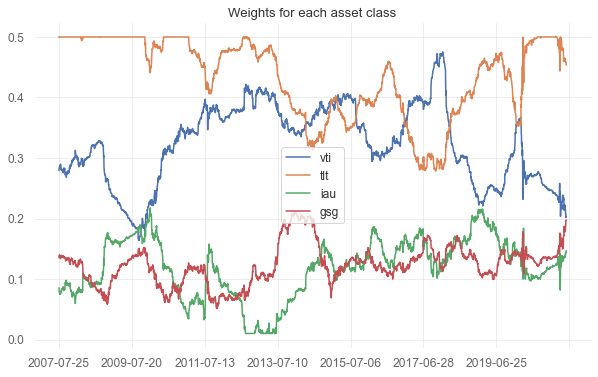

In [12]:
weight_df.plot(title = 'Weights for each asset class')

In [13]:
max_div_return = (weight_df['vti'] * return_df.iloc[252:, :]['vti'] +
                  weight_df['tlt'] * return_df.iloc[252:, :]['tlt'] + 
                  weight_df['iau'] * return_df.iloc[252:, :]['iau'] +
                  weight_df['gsg'] * return_df.iloc[252:, :]['gsg'])
        
max_div_return

2007-07-25    0.002205
2007-07-26   -0.004458
2007-07-27   -0.002834
2007-07-30    0.003076
2007-07-31    0.001080
                ...   
2021-05-13   -0.001327
2021-05-14    0.010107
2021-05-17    0.003095
2021-05-18   -0.003733
2021-05-19   -0.005739
Length: 3480, dtype: float64

In [14]:
max_div_return.index

Index(['2007-07-25', '2007-07-26', '2007-07-27', '2007-07-30', '2007-07-31',
       '2007-08-01', '2007-08-02', '2007-08-03', '2007-08-06', '2007-08-07',
       ...
       '2021-05-06', '2021-05-07', '2021-05-10', '2021-05-11', '2021-05-12',
       '2021-05-13', '2021-05-14', '2021-05-17', '2021-05-18', '2021-05-19'],
      dtype='object', length=3480)

인덱스가 DatetimeIndex 형식이 아니므로 DatetimeIndex 형식으로 변환합니다.

In [15]:
max_div_return.index = pd.to_datetime(max_div_return.index)

In [16]:
max_div_return.index

DatetimeIndex(['2007-07-25', '2007-07-26', '2007-07-27', '2007-07-30',
               '2007-07-31', '2007-08-01', '2007-08-02', '2007-08-03',
               '2007-08-06', '2007-08-07',
               ...
               '2021-05-06', '2021-05-07', '2021-05-10', '2021-05-11',
               '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-17',
               '2021-05-18', '2021-05-19'],
              dtype='datetime64[ns]', length=3480, freq=None)

위험 균형 전략에 목표 변동성을 더했던(risk parity with target vol) 테스트보다 샤프 비율이 잘 나옵니다. 레버리지를 사용하면 샤프 비율이 내려가는 경우가 많으니 감안해서 보아야 하지만, maximum diversification도 괜찮은 방법이라는 것 정도는 알 수 있습니다.

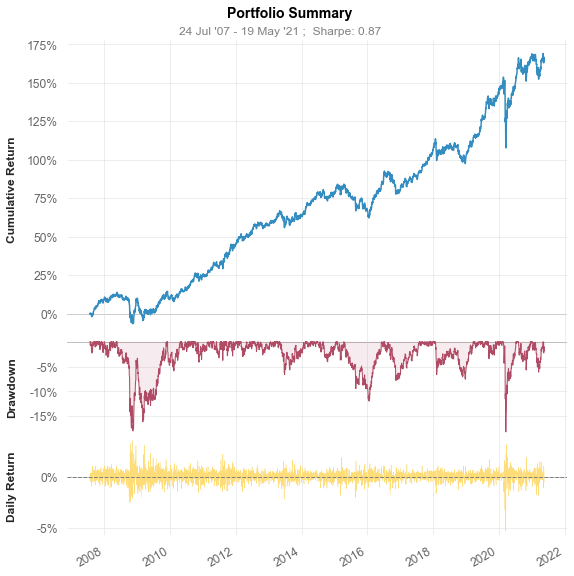

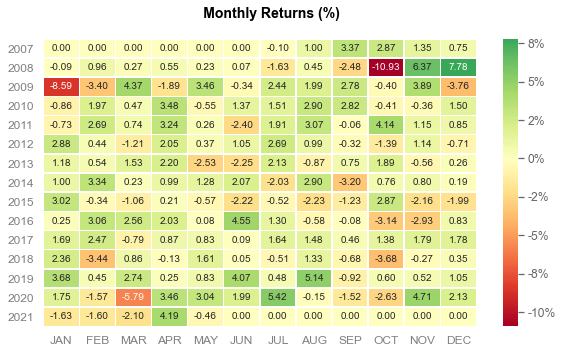

In [17]:
quantstats.reports.plots(max_div_return, mode='basic')

In [18]:
quantstats.reports.metrics(max_div_return, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2007-07-25
End Period                 2021-05-19
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          163.93%
CAGR%                      7.27%
Sharpe                     0.87
Sortino                    1.23
Max Drawdown               -18.15%
Longest DD Days            553
Volatility (ann.)          8.54%
Calmar                     0.4
Skew                       -0.43
Kurtosis                   7.5

Expected Daily %           0.03%
Expected Monthly %         0.58%
Expected Yearly %          6.68%
Kelly Criterion            7.72%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.86%
Expected Shortfall (cVaR)  -0.86%

Payoff Ratio               0.98
Profit Factor              1.17
Common Sense Ratio         1.12
CPC Index                  0.62
Tail Ratio                 0.96
Outlier Win Ratio          3.8
Outlier Loss Ratio         3.71


In [19]:
quantstats.reports.html(max_div_return, output='Report_MAXDIV.html', title='Maximum Diversification')